# TP 3 : Optimal Execution and Market Making

### Louis-Marie Lovichi - Thomas Seror - Elie Jabbour - Elias Moussa

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## I. Optimal split of orders across liquidity pools

### 1) Outils

On écrit ici deux algorithmes nécessaires pour la suite du TP :

- Algorithme de projection sur le simplexe.
- Algorithme de pré-processing des données.

In [2]:
def projection_simplexe(v, z=1):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    rho = np.nonzero(u * np.arange(1, n+1) > cssv)[0][-1]
    theta = cssv[rho] / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

In [3]:
def get_data(data_folder_path, assets):

    if not os.path.exists(data_folder_path):
        print("Le dossier n'est pas trouvable à l'adresse suivante", data_folder_path)

    else:
        
        dico_data = {asset: None for asset in assets}

        for filename in os.listdir(data_folder_path):
            if filename[:-3] in dico_data:
                file_path = os.path.join(data_folder_path, filename)
                dico_data[filename[:-3]] = pd.read_hdf(file_path)
    
    return dico_data

### 2) Experiments

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_folder_path = os.path.join(parent_directory, 'Stock Data') # nom du dossier contenant les données à la racine.

assets = ['BOUYGUES', 'LVMH', 'SANOFI', 'TOTAL']

dico_data = get_data(data_folder_path, assets)

In [5]:
# classe objet permettant de récupérer les données sur une liste donnée en entrée.

class Equities():


    def __init__(self, 
                 assets: list[str], 
                 dico_data: dict) -> None:
        
        self.assets = assets
        self.dico_data = dico_data


    def compute_prices_volumes(self, 
                               T: int, 
                               year: int=2011,
                               month: int=12,
                               day: int=5,
                               nb_day = 12) -> tuple[dict, dict]:

        dico_prices = {}
        dico_volumes = {}
        date_debut = pd.Timestamp(year=year, month=month, day=day, hour=9)
        date_fin = date_debut + pd.Timedelta(days=nb_day)
        
        index_df = []

        for asset in self.assets:

            df = self.dico_data[asset].resample(f'{T}min').mean()
            df = df[df['TradedQty']>0]
            df = df.loc[(df.index >= date_debut) & (df.index <= date_fin)]
            dico_prices[asset] = df['TradedPrice']
            index_df.append(df.index)

            df = self.dico_data[asset].resample(f'{T}min').sum()
            df = df[df['TradedQty']>0]
            df = df.loc[(df.index >= date_debut) & (df.index <= date_fin)]
            dico_volumes[asset] = df['TradedQty']
            index_df.append(df.index)
        
        intersect_df = index_df[0]
        for i in range(1, len(index_df)):
            intersect_df = intersect_df.intersection(index_df[i])
        
        for (key, value) in dico_prices.items():
            dico_prices[key] = value.loc[intersect_df]
        for (key, value) in dico_volumes.items():
            dico_volumes[key] = value.loc[intersect_df]

        return dico_prices, dico_volumes

On récupère les données associées aux assets qui nous intéressent sur une certaine plage de temps.

In [6]:
T = 1
equities = Equities(assets, dico_data)
dico_prices, dico_volumes = equities.compute_prices_volumes(T, nb_day=30)

In [7]:
# classe objet permettant de créer un DarkPool pour un asset particulier, traded_asset en prenant une liste d'assets en référence, assets.

class DarkPool: 

    def __init__(self, 
                 traded_asset: str, 
                 assets: list[str],
                 alpha: np.array,
                 beta: np.array,
                 rho: np.array) -> None:
        
        self.beta = beta
        self.alpha = alpha
        self.rho = rho
        self.traded_asset = traded_asset

        reference_assets = assets.copy()
        reference_assets.remove(traded_asset)
        self.reference_assets = reference_assets
        self.dico_darkpools = None


    def create_darkpools(self, 
                         dico_prices: dict,
                         dico_volumes: dict) -> None:
        
        dico_darkpools = {}

        traded_volume = dico_volumes[self.traded_asset]
        mean_traded_volume = traded_volume.mean()

        for (i, asset) in enumerate(self.reference_assets):

            alpha = self.alpha[i]
            beta = self.beta[i]

            price_asset = dico_prices[asset]
            mean_price_asset = price_asset.mean()

            darkpool = beta*((1-alpha)*traded_volume + alpha*price_asset*mean_traded_volume/mean_price_asset)

            dico_darkpools[asset] = darkpool

        self.dico_darkpools = dico_darkpools

    # allocation par algorithme stochastique
    def compute_stochastic_allocation(self,
                                      r0: np.array,
                                      c = 0.01) -> tuple[pd.DataFrame, np.array]:

        dates = dico_volumes[self.traded_asset].index
        traded_volume = dico_volumes[self.traded_asset]
        allocation = np.zeros((len(dates), len(self.reference_assets)))
        
        n = 1
        gamma = c/n

        for (j, date) in enumerate(dates):

            H = np.zeros(len(self.reference_assets))

            for (i, asset) in enumerate(self.reference_assets):
                
                if r0[i]*traded_volume[date] < self.dico_darkpools[asset][date]:
                    H[i] = self.rho[i]

            H -= np.mean(H)
            H *= traded_volume[date]
            r0 += gamma*H

            # mise à jour de gamma (gamma_n = 1/n)
            n += 1
            gamma = c/n
            
            allocation[j] = projection_simplexe(r0.copy())
        
        return dates, allocation
    
    # allocation look-ahead en benchmark
    def compute_oracle_allocation(self):
        
        dates = dico_volumes[self.traded_asset].index
        traded_volume = np.array(dico_volumes[self.traded_asset])

        allocation = np.zeros((len(dates), len(self.reference_assets)))

        indices_tries = sorted(range(len(self.rho)), key=lambda i: self.rho[i], reverse=True)
        remaining_quantity_to_allocate = np.ones(len(dates))
        for i in indices_tries:

            allocation[:, i] = np.minimum(remaining_quantity_to_allocate, np.array(self.dico_darkpools[self.reference_assets[i]])/traded_volume)
            remaining_quantity_to_allocate -= allocation[:, i]
        
        return dates, allocation

    # calcul du coût des trades
    def compute_cost(self, 
                     allocation: np.array) -> np.array:
        
        price_asset = dico_prices[self.traded_asset].astype(float)
        traded_volume = np.array(dico_volumes[self.traded_asset]).astype(float)
        cost = traded_volume.copy()

        for (i, asset) in enumerate(self.reference_assets):
            
            cost -= self.rho[i]*np.minimum(allocation[:, i]*traded_volume, np.array(self.dico_darkpools[asset]).astype(float))
            
        cost *= price_asset
        
        return cost

On crée alors le DarkPool associé.

In [8]:
alpha = np.array([0.4, 0.7, 0.5])
beta = np.array([0.2, 0.1, 0.15])
rho = np.array([0.03, 0.05, 0.02])

darkpool = DarkPool("TOTAL", assets, alpha, beta, rho)
darkpool.create_darkpools(dico_prices, dico_volumes)

On calcule les allocations.

In [9]:
r0 = np.ones(3)/3
dates, allocation_sto = darkpool.compute_stochastic_allocation(r0)

dates, allocation_oracle = darkpool.compute_oracle_allocation()

On calcule les coûts associées aux allocations.

In [10]:
cost_oracle = darkpool.compute_cost(allocation_oracle)
cost_sto = darkpool.compute_cost(allocation_sto)

no_darkpool_allocation = np.zeros(allocation_oracle.shape)
cost_no_darkpool = darkpool.compute_cost(no_darkpool_allocation)

On calcule les réductions de coût associées pour en calculer les performances.

In [11]:
CR_opti = (cost_no_darkpool-cost_sto)
CR_oracle = (cost_no_darkpool-cost_oracle)

performance = CR_opti/CR_oracle
performance

Time
2011-12-05 09:00:00    1.0
2011-12-05 09:01:00    1.0
2011-12-05 09:02:00    1.0
2011-12-05 09:03:00    1.0
2011-12-05 09:04:00    1.0
                      ... 
2011-12-30 17:25:00    1.0
2011-12-30 17:26:00    1.0
2011-12-30 17:27:00    1.0
2011-12-30 17:28:00    1.0
2011-12-30 17:29:00    1.0
Name: TradedPrice, Length: 6861, dtype: float64

On trace la moyenne mobile de la performance ainsi que les allocations au cours du temps.

In [12]:
nb_donnees_par_jour = int(8.5*60/T)

# calcul moyenne mobile
window_size = 100
y_ma = np.convolve(np.array(performance.values), np.ones(window_size)/window_size, mode='valid')

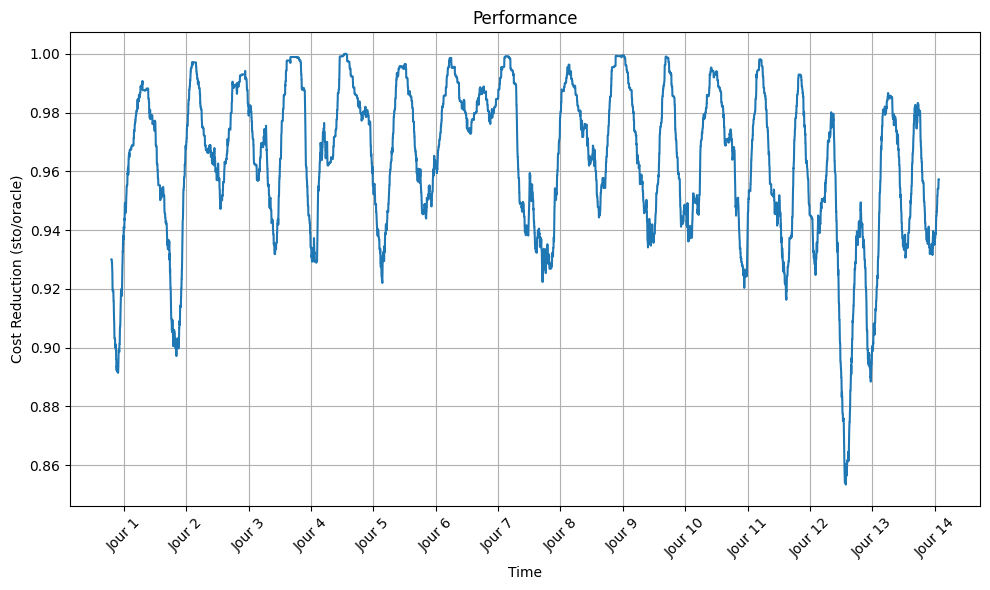

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_ma, linestyle='-')
plt.xlabel('Time')
plt.ylabel('Cost Reduction (sto/oracle)')
plt.title('Performance')

indices = np.arange(window_size, len(y_ma), nb_donnees_par_jour)
jours = [f'Jour {i//nb_donnees_par_jour + 1}' for i in indices]
plt.xticks(indices, jours, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

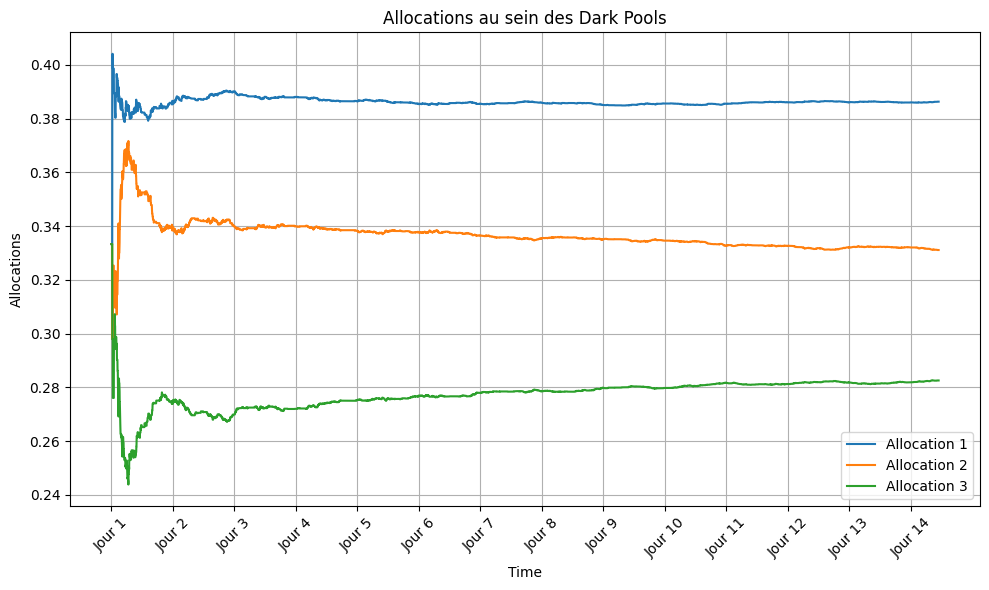

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(allocation_sto[:, 0], linestyle='-', label='Allocation 1')
plt.plot(allocation_sto[:, 1], linestyle='-', label='Allocation 2')
plt.plot(allocation_sto[:, 2], linestyle='-', label='Allocation 3')
plt.xlabel('Time')
plt.ylabel('Allocations')
plt.title('Allocations au sein des Dark Pools')

indices = np.arange(0, len(performance.values), nb_donnees_par_jour)
jours = [f'Jour {i//nb_donnees_par_jour + 1}' for i in indices]
plt.xticks(indices, jours, rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En se plaçant dans une configuration « shortage », on observe que la convergence est très rapide. Par ailleurs, on peut formuler les remarques suivantes : 

- Très logiquement, l'allocation est plus importante pour les darkpools dont le discount est important à condition que le volume offert par le darkpool (piloté par $\beta$) est suffisante, on comprend donc naturellement les résultats obtenus.

- Les performances oscillent en moyenne entre 90 et 100 $\%$ par rapport à benchmark.

## II. Market Making

In [15]:
import seaborn as sns

%matplotlib inline

On crée plusieurs fonctions outils adaptées au problème :

In [16]:
def import_data(file_path, start_date, num_day):
    df = pd.read_hdf(file_path, sep='\t', index_col='Time', parse_dates=True)
    date_debut = pd.to_datetime(start_date)
    date_fin = date_debut + pd.Timedelta(days=num_day)
    df =  df[(df.index >= date_debut) & (df.index <= date_fin)]

    return df

Use the datasets on Paris Bourse: you have 4 assets (Bouygues, LVMH, Sanofi and Total). Select two weeks of data.


In [17]:
df_total = import_data('../Stock Data/TOTAL.h5', '2011-01-03', 1)
df_bouygues = import_data('../Stock Data/BOUYGUES.h5', '2011-01-03', 1)
df_lvmh = import_data('../Stock Data/LVMH.h5', '2011-01-03', 1)
df_sanofi = import_data("../Stock Data/SANOFI.h5",'2011-01-03', 1)


df_total

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.988,40.190,70,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,15,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,67,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,20,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,250,40.010,40.19,660800,40700,1
...,...,...,...,...,...,...,...
2011-01-03 17:29:50.528,40.500,62,40.500,40.51,14500,144200,-1
2011-01-03 17:29:52.012,40.500,14,40.495,40.50,39100,16200,1
2011-01-03 17:29:52.012,40.500,148,40.495,40.50,39100,16200,1


### 1. Fillrates

On écrit dans la classe objet suivante, l'intégralité des méthodes qui seront utiles dans la suite du TP.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

class Fillrates:

    def __init__(self, asset_data: pd.DataFrame):
        """
        Initialise la classe BarrierTouchSimulator avec les données des actifs.

        Args:
            asset_data (pd.DataFrame): DataFrame contenant les données des actifs.
        """
        asset_data["MidPrice"] = 0.5 * (asset_data["BidPrice"] + asset_data["AskPrice"])
        asset_data["Spread"]= asset_data["AskPrice"] - asset_data["BidPrice"]
        self.asset_data = asset_data

    def simulate_touches(self, barrier_distance: float, update_interval: int) -> pd.DataFrame:
        """
        Simule les touches de barrière pour les actifs.

        Args:
            barrier_distance (float): Distance de la barrière par rapport aux prix bid et ask.
            update_interval (int): Intervalle de mise à jour de la barrière.

        Returns:
            pd.DataFrame: DataFrame contenant les résultats des touches de barrière.
        """
        results = []
        last_update_time = self.asset_data.index[0] - pd.Timedelta(minutes=update_interval)

        bid_touches, ask_touches = 0, 0

        for current_time, row in self.asset_data.iterrows():
            if (current_time - last_update_time) >= pd.Timedelta(minutes=update_interval):
                if last_update_time != self.asset_data.index[0] - pd.Timedelta(minutes=update_interval):
                    results.append({'DateTime': last_update_time, 
                                    'BidTouches': bid_touches, 
                                    'AskTouches': ask_touches, 
                                    'Spread': ask_barrier - bid_barrier - 2 * barrier_distance})

                bid_touches, ask_touches = 0, 0
                last_update_time = current_time

                bid_barrier = row['BidPrice'] - barrier_distance
                ask_barrier = row['AskPrice'] + barrier_distance

            if row['TradedPrice'] <= bid_barrier:
                bid_touches += 1
            if row['TradedPrice'] >= ask_barrier:
                ask_touches += 1

        results.append({'DateTime': last_update_time, 
                        'BidTouches': bid_touches, 
                        'AskTouches': ask_touches, 
                        'Spread': ask_barrier - bid_barrier - 2 * barrier_distance})

        return pd.DataFrame(results)
    
    def count_touches(self, barrier_distance, update_interval):

        out = self.simulate_touches(barrier_distance, update_interval)
        
        return out[["BidTouches","AskTouches"]].cumsum().iloc[-1,:].sum()

    def plot_simulation(self, barrier_distance, update_interval):
        """
        Trace un graphique illustrant la simulation des touches de barrière.

        Args:
            barrier_distance (float): Distance de la barrière par rapport aux prix bid et ask.
            update_interval (int): Intervalle de mise à jour de la barrière.
        """
        touch_results = self.simulate_touches(barrier_distance, update_interval)
        stop = 50

        plt.figure(figsize=(20, 6))
        
        plt.subplot(1, 2, 1)
        self.asset_data.loc[touch_results.iloc[1]["DateTime"]:touch_results.iloc[stop]["DateTime"]]["TradedPrice"].plot(figsize=(10, 6))
        plt.title(f'Traded Price for Barrier Distance={barrier_distance}, Update Interval={update_interval}')
        plt.xlabel('DateTime')
        plt.ylabel('Traded Price')
        
        plt.subplot(1, 2, 2)
        touch_results.iloc[:stop,:].plot(x='DateTime', y=['BidTouches', 'AskTouches'], kind='bar', figsize=(20, 6), ax=plt.gca())
        plt.title(f'Bid/Ask Touches for Barrier Distance={barrier_distance}, Update Interval={update_interval}')
        
        plt.tight_layout()
        plt.show()
    
    def get_vol_spread_volume(self):

        ohlc1 = self.asset_data["MidPrice"].resample("D").ohlc().dropna()
        Vol = np.sqrt( 0.5 * (ohlc1['high']-ohlc1['low'])**2 - (2*np.log(2)-1) * (ohlc1['close'] - ohlc1['open'])**2 )

        spread = self.asset_data["Spread"].resample("D").mean().dropna()
        df = pd.DataFrame(spread)
        df["vol"] = Vol.values

        volume = self.simulate_touches(0.01, 1)
        volume.set_index("DateTime", inplace = True)
        volume = volume[["BidTouches","AskTouches"]].sum(axis=1)
        volume = volume.resample("D").sum()
        df["volumes"] = volume[volume>0].values

        return df
    

    def static_simulate_barrier_touch(self, da, db, t):
        """
        Simule le placement de barrières et enregistre chaque fois qu'elles sont touchées.
        
        :param df: DataFrame contenant les données de marché, indexé par DateTime.
        :param d: distance en ticks pour ajuster les barrières du bid et de l'ask.
        :param t: intervalle de temps en minutes pour réajuster les barrières.
        :return: DataFrame des résultats avec la date de mise en place, et le nombre de touches pour chaque barrière.
        """
        results = []
        last_update_time = self.asset_data.index[0] - pd.Timedelta(minutes=t)  # Pour s'assurer de mettre à jour au premier pas
        nb_actions= 0
        inventary = []
        
        # Initialisation des compteurs de touches
        bid_touches, ask_touches = 0, 0

        for current_time, row in self.asset_data.iterrows():
            # Mise à jour des barrières tous les t minutes
            if (current_time - last_update_time) >= pd.Timedelta(minutes=t):
                if last_update_time != self.asset_data.index[0] - pd.Timedelta(minutes=t):
                    # Enregistrement des résultats de la période précédente
                    results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier - da - db})
                
                # Réinitialisation des compteurs de touches
                bid_touches, ask_touches = 0, 0
                last_update_time = current_time
                
                # Mise à jour des barrières
                bid_barrier = row['BidPrice'] - db
                ask_barrier = row['AskPrice'] + da
            
            # Vérification si les barrières sont touchées : à checker 
            if row['TradedPrice'] <= bid_barrier:
                bid_touches += 1
                nb_actions-=1
                inventary.append(nb_actions)
            if row['TradedPrice'] >= ask_barrier:
                ask_touches += 1
                nb_actions+=1
                inventary.append(nb_actions)
        
        # Enregistrement des résultats de la dernière période
        results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier - da - db})
        
        return inventary
    
    def get_best_da_db_inventory(self, 
                                 da_range: list=[0.001 * i for i in range(1, 10)], 
                                 db_range: list=[0.001 * i for i in range(1, 10)],
                                 t=10):

        best_da = None
        best_db = None
        best_diff = float('inf')

        # Itération sur toutes les combinaisons de da et db
        for da in da_range:
            for db in db_range:
                inventary = self.static_simulate_barrier_touch(da, db, t)
                diff = abs(inventary[-1])
                if diff < best_diff:
                    best_diff = diff
                    best_da = da
                    best_db = db

        return best_da, best_db, inventary
    
    def get_best_ca_cb(self, best_da, best_db):

        df = self.get_vol_spread_volume()
        best_ca = best_da/df['vol'][0]
        best_cb = best_db/df['vol'][0]

        return best_ca, best_cb
    
    def get_pnl(self, best_ca, best_cb):

        df = self.get_vol_spread_volume()
        output = pd.DataFrame()
        i=0
        for item, row in df.iterrows():

            df_total_ = import_data('../Stock Data/TOTAL.h5', item, 1) 
            inventaire = self.static_simulate_barrier_touch(best_ca*row["vol"], best_cb*row["vol"],5)
            output.loc[i,"inventory"]= inventaire[-1]
            output.loc[i,"price"]= (df_total_.iloc[-1,:]["BidPrice"] + df_total_.iloc[-1,:]["AskPrice"])/2
            output.loc[i,"PNL"]= inventaire[-1]*(df_total_.iloc[-1,:]["BidPrice"] + df_total_.iloc[-1,:]["AskPrice"])/2
            output.loc[i,"Spread"]= row["Spread"]
            output.loc[i,"vol"]= row["vol"]
            i+=1

        return output  

On obtient alors les résultats illustrés pour différentes valeurs de $d$ et de $t$ :

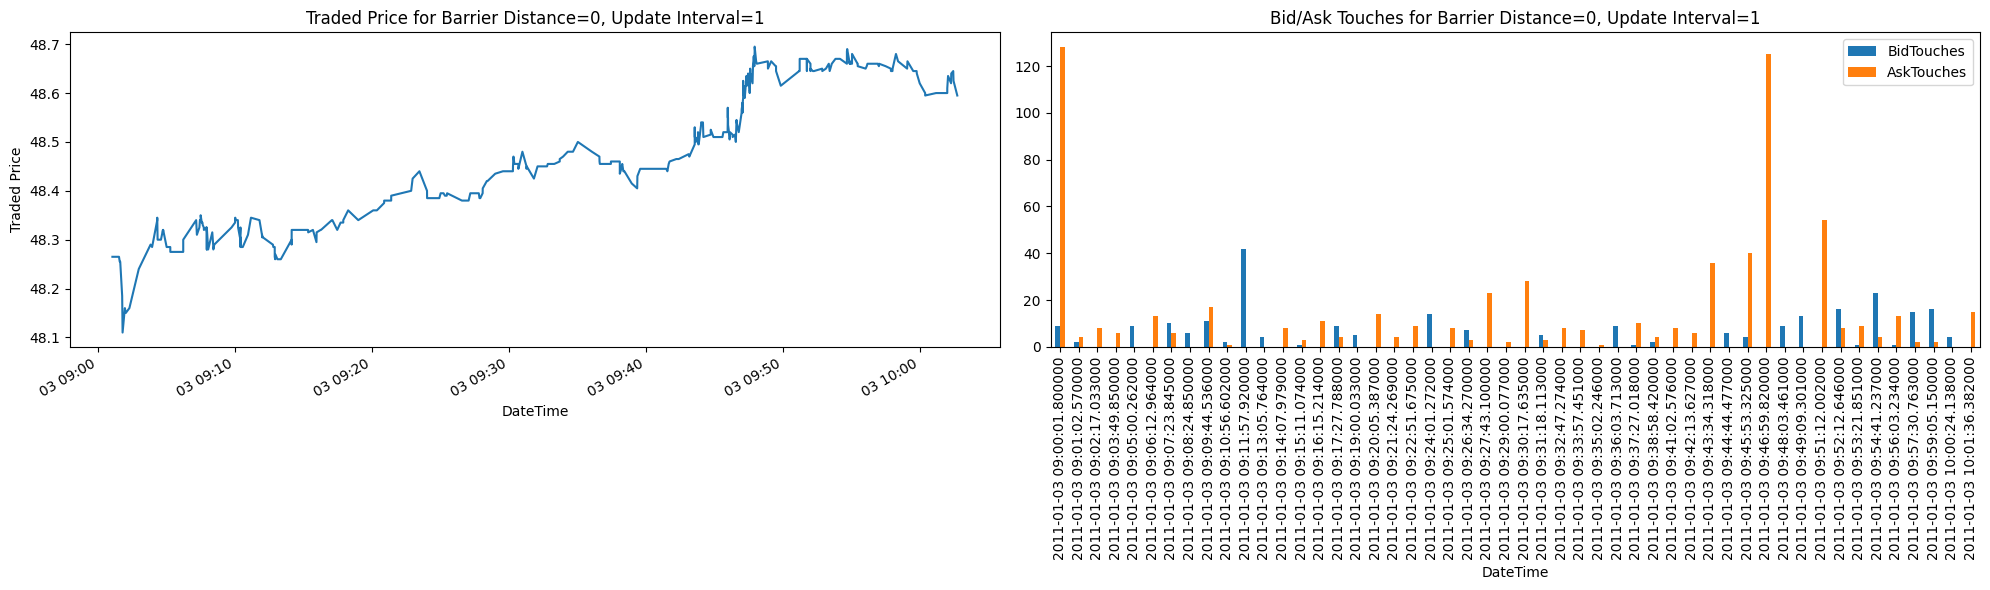

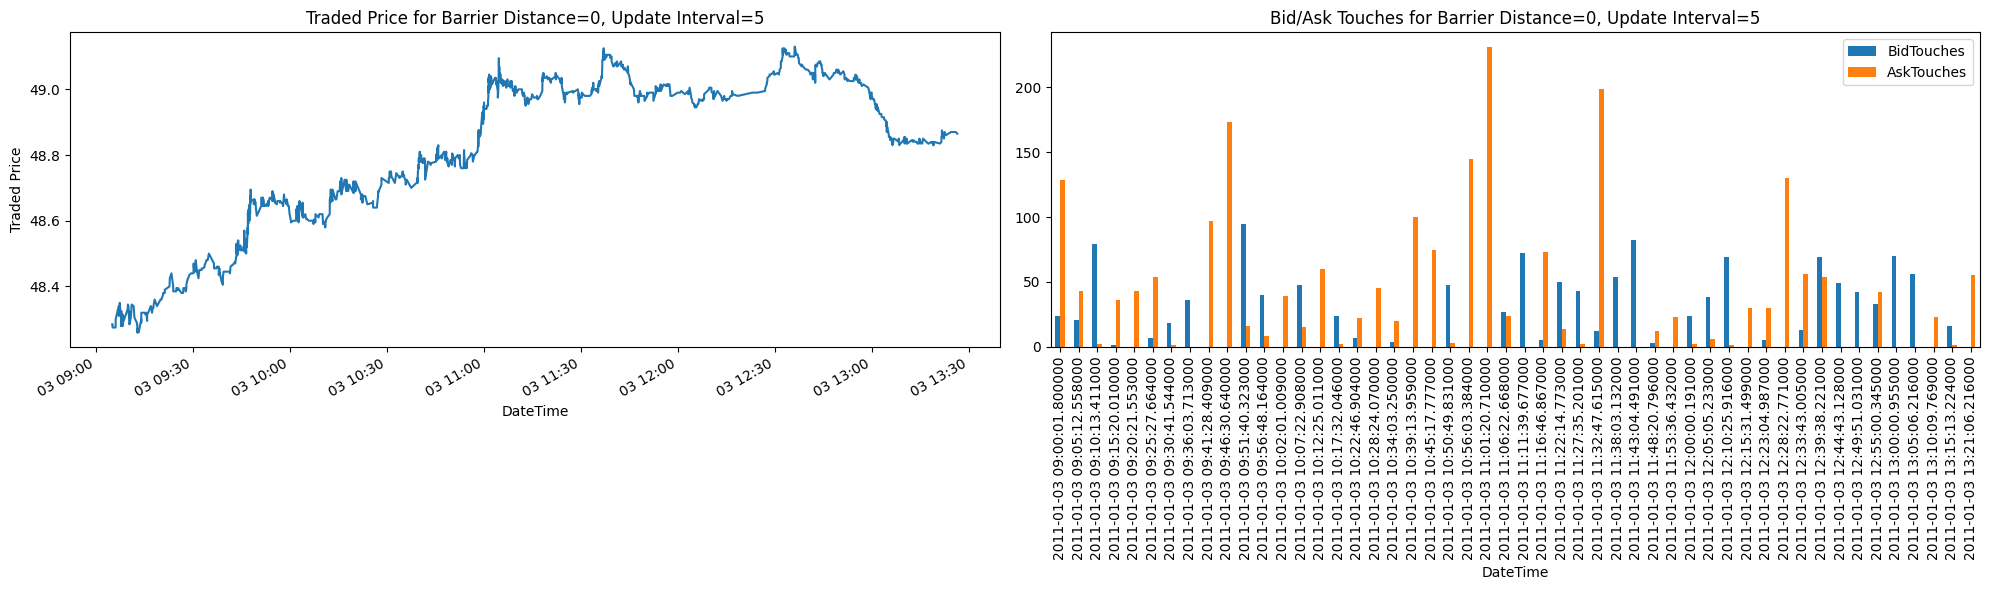

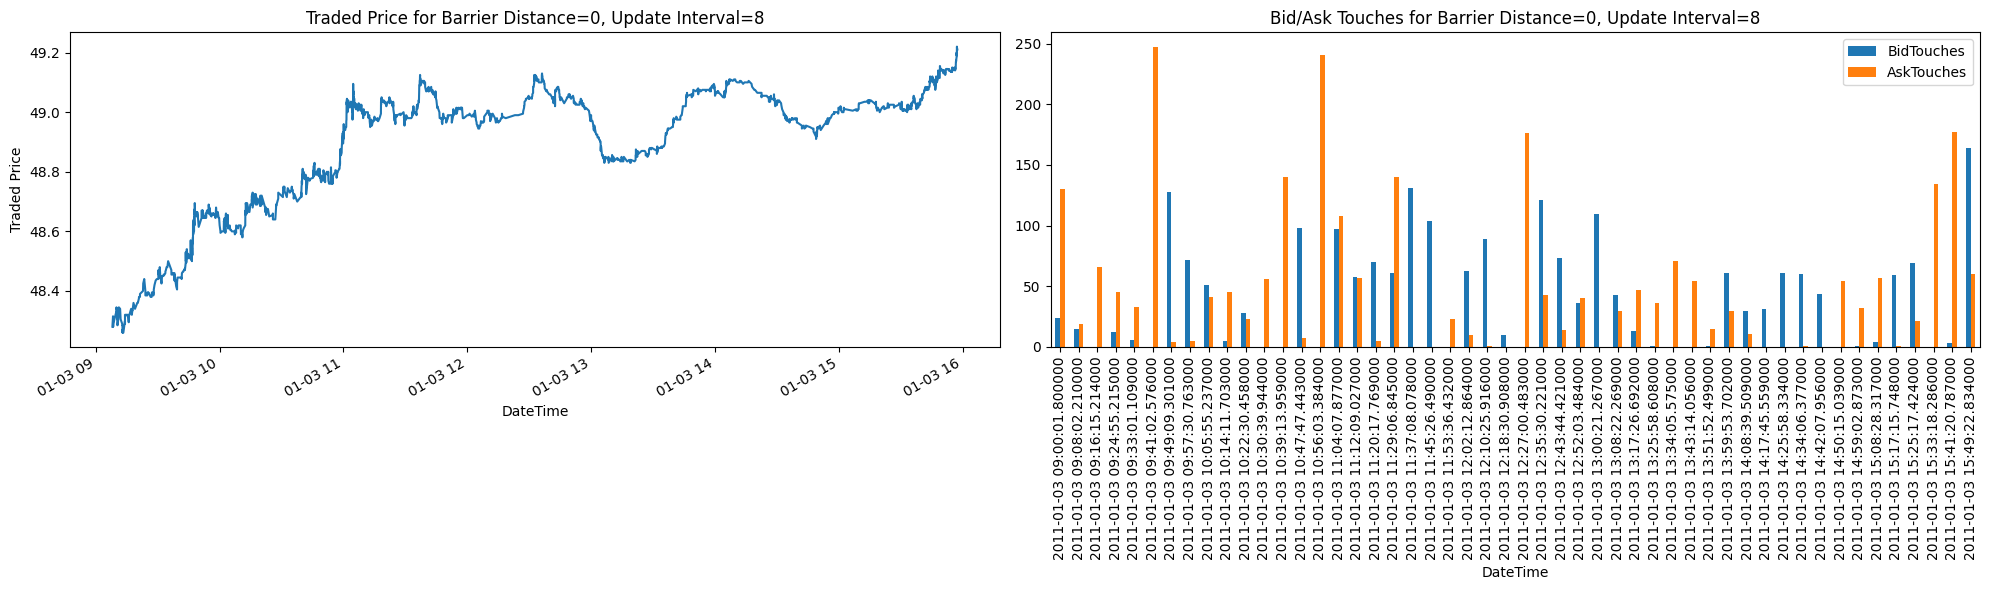

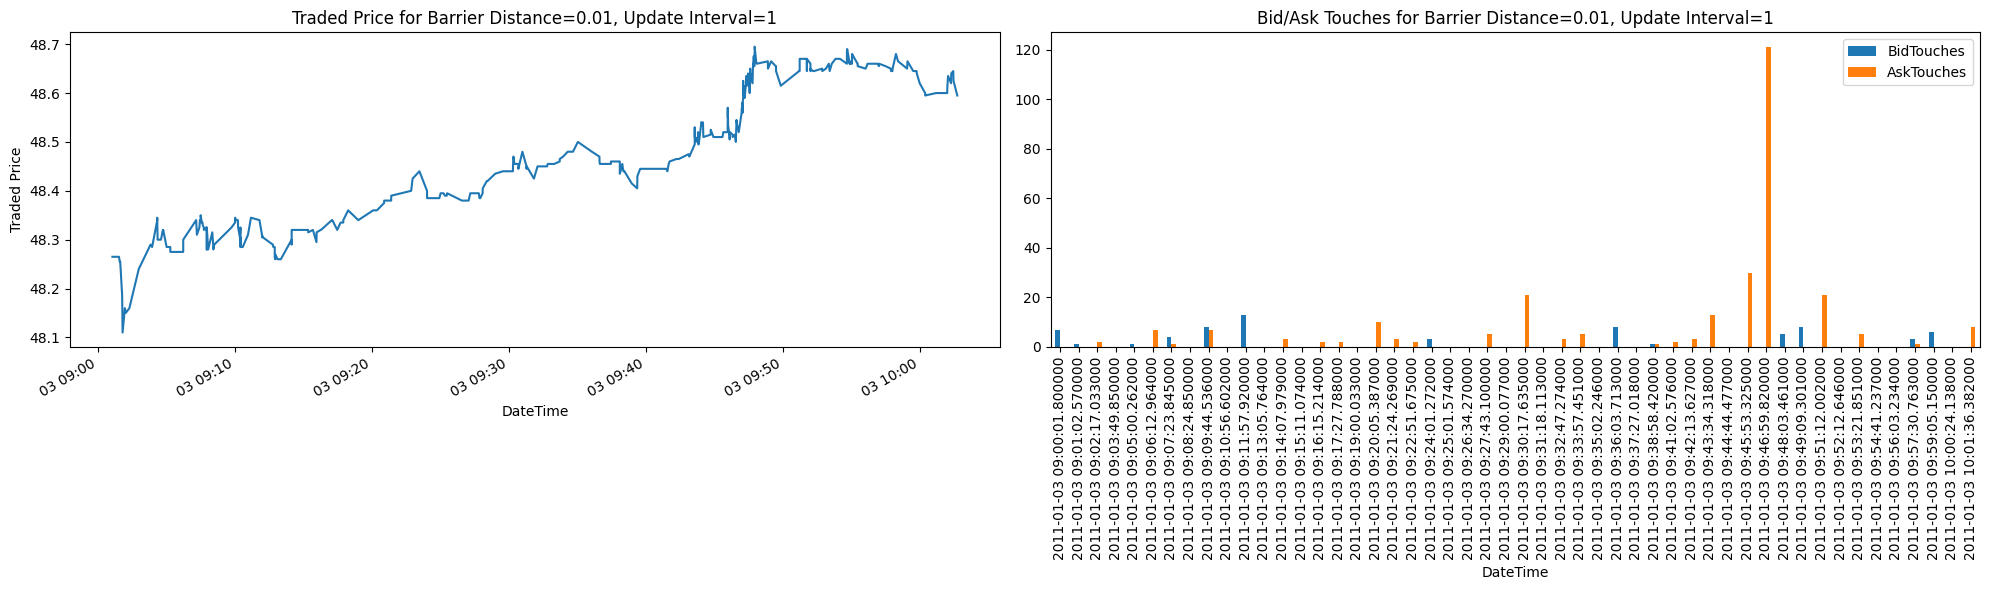

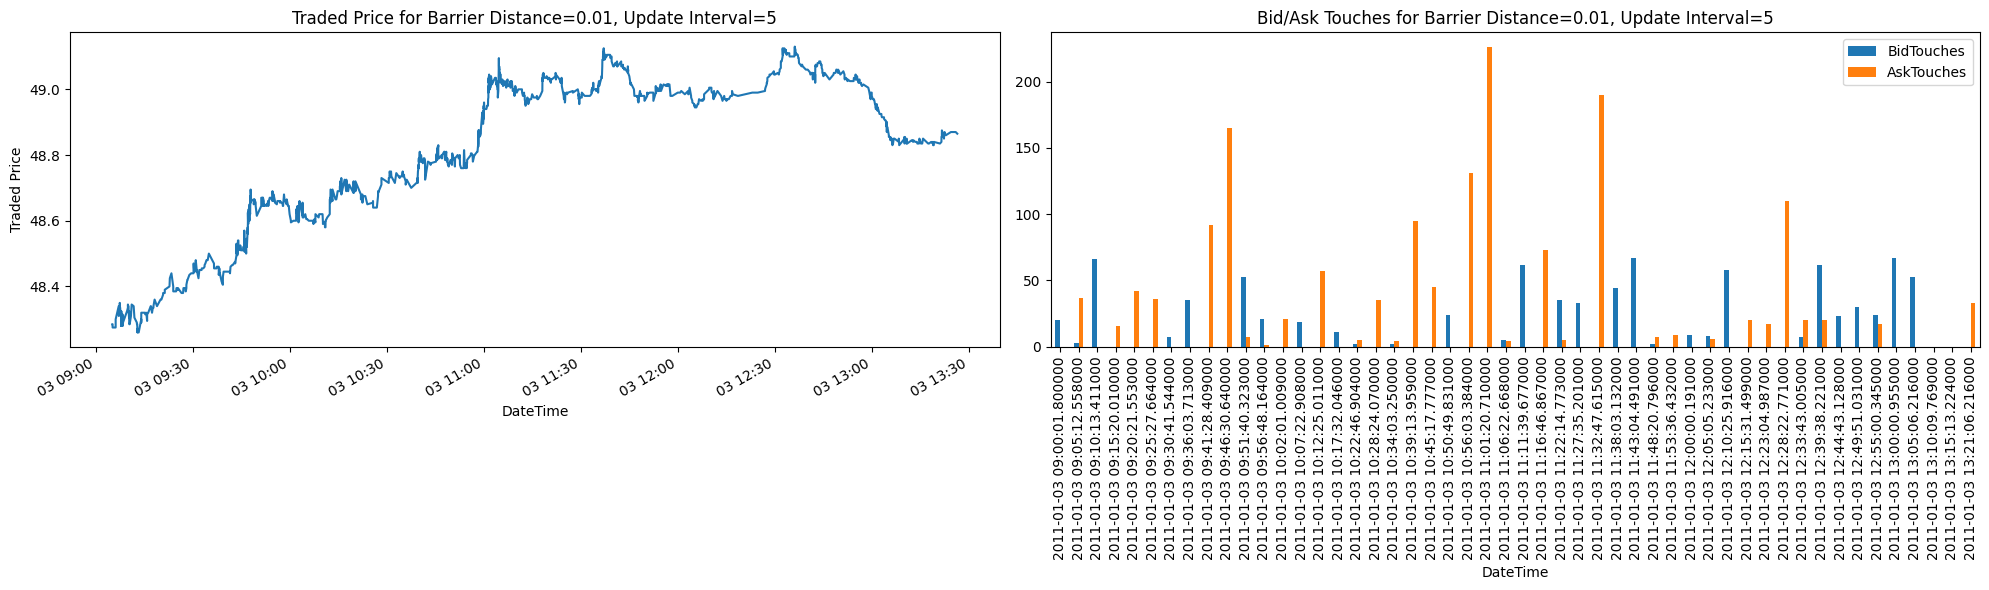

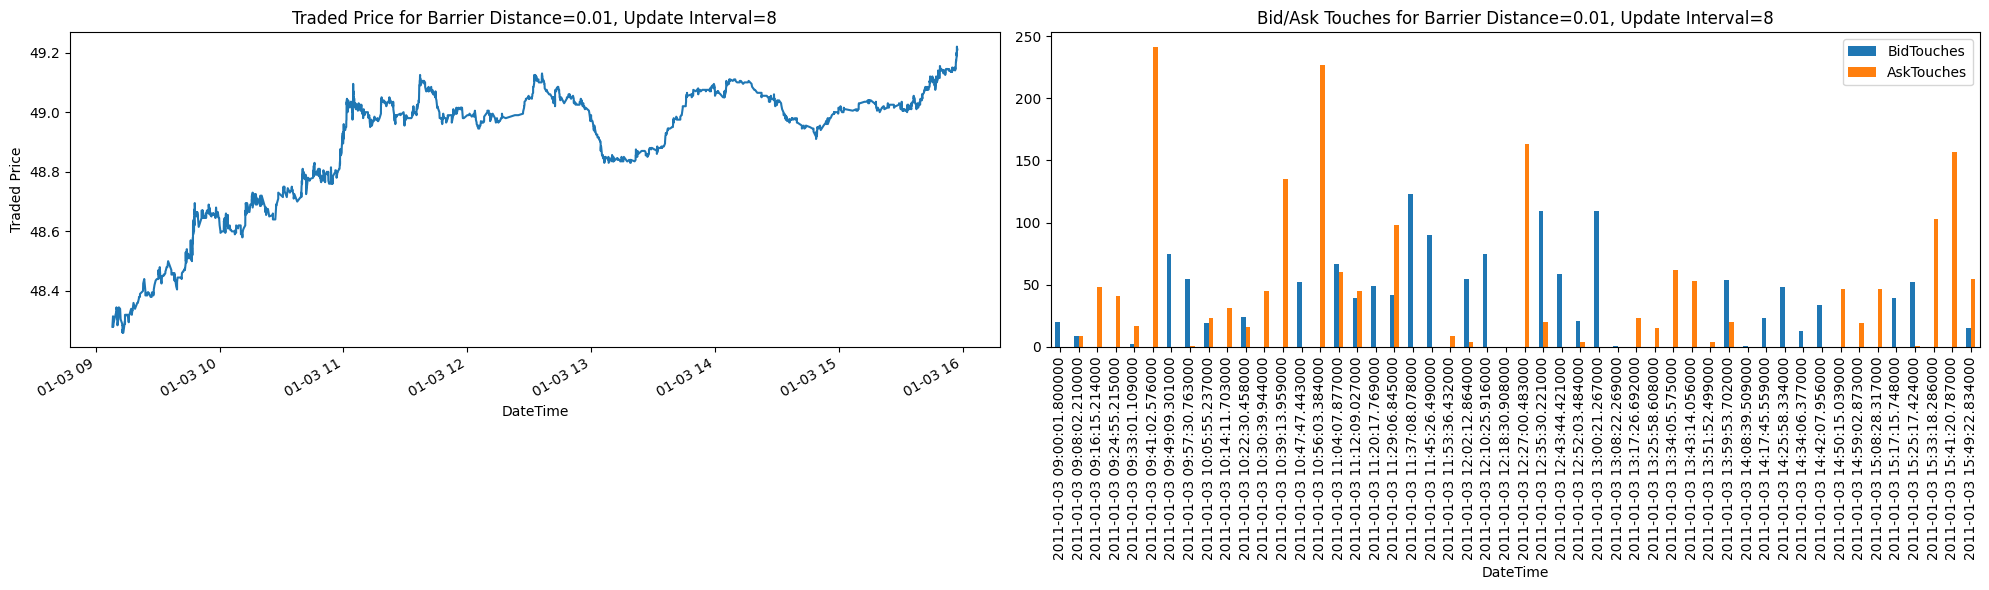

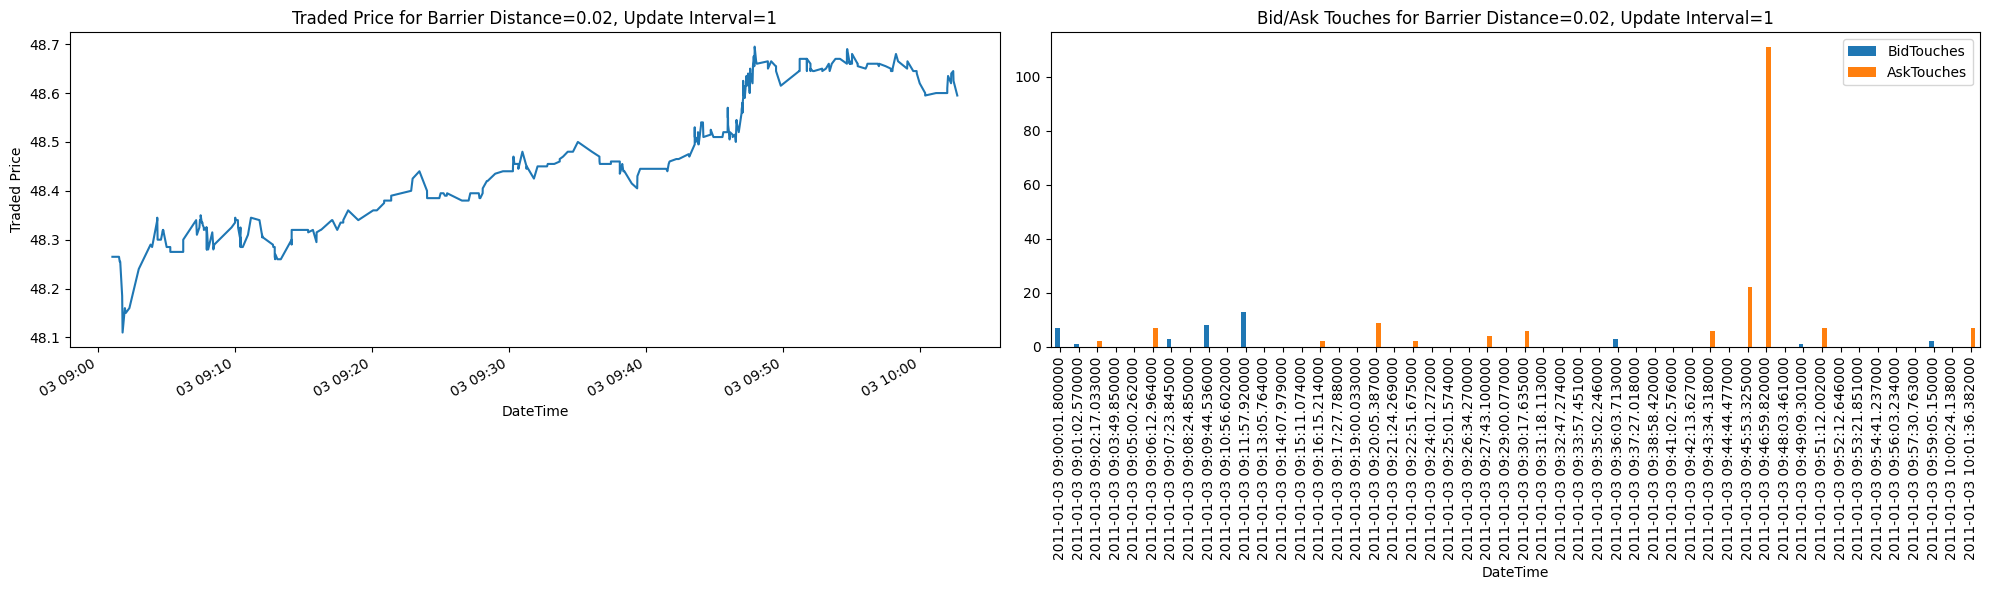

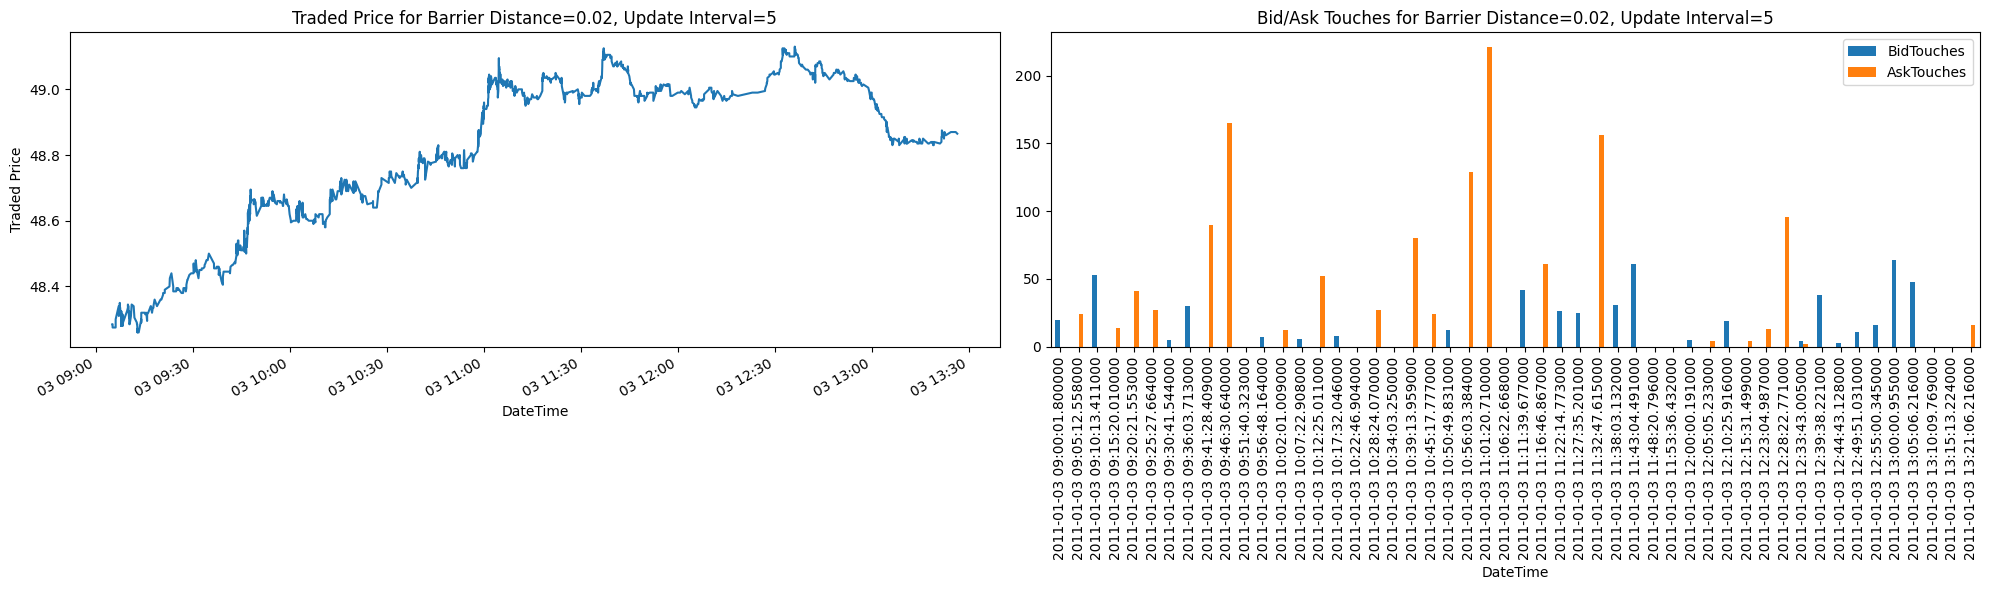

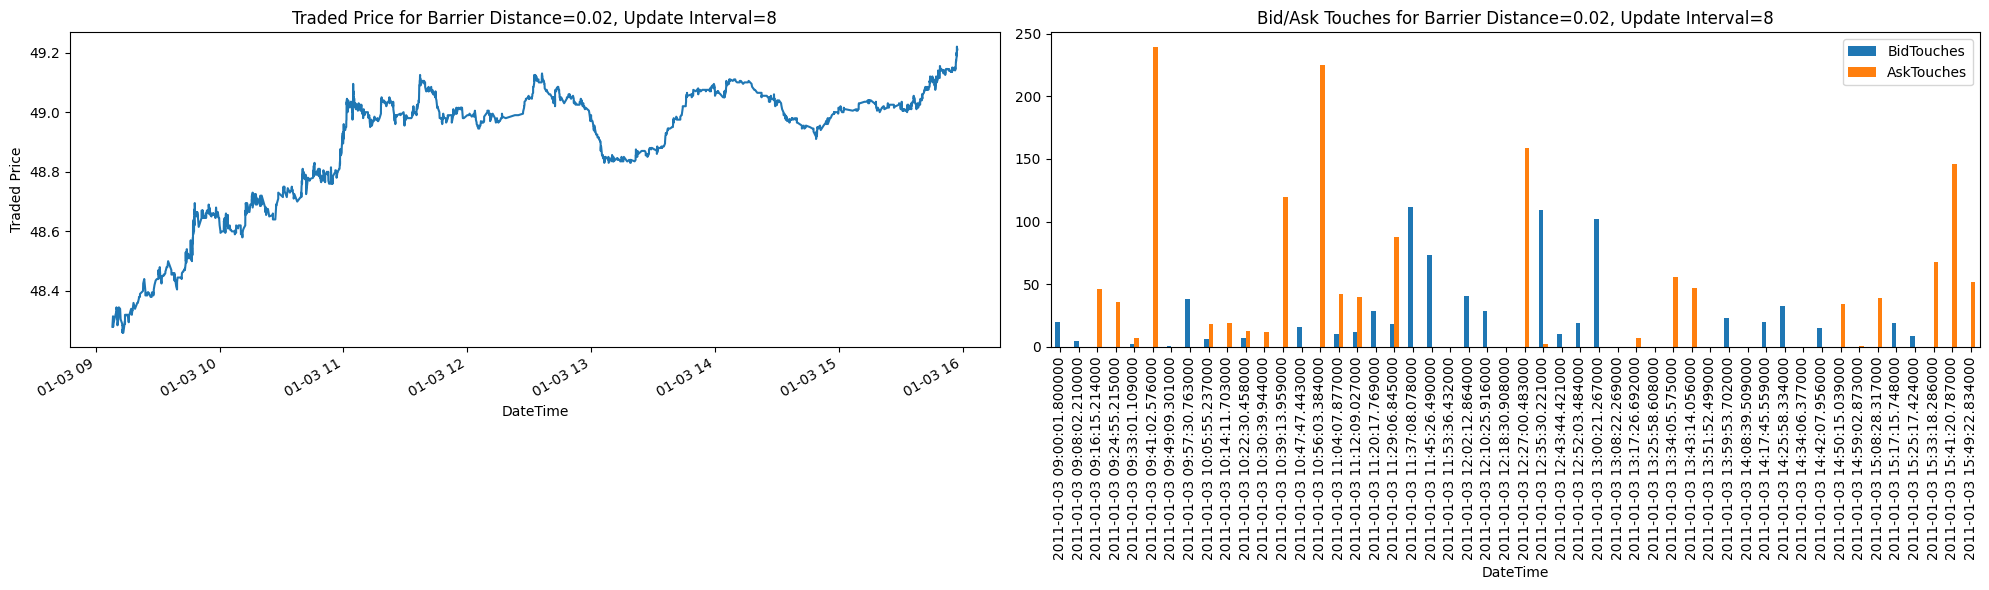

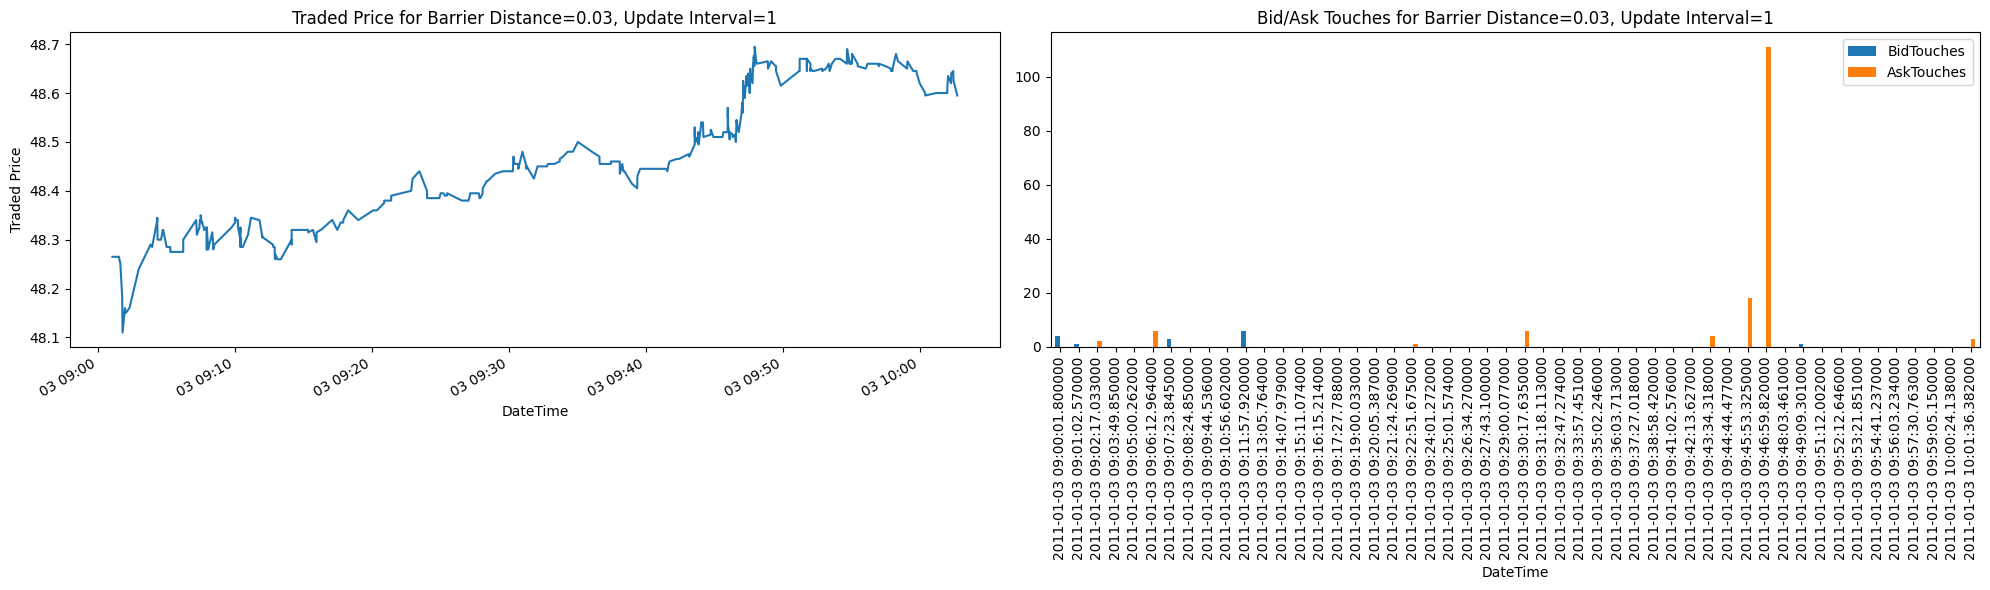

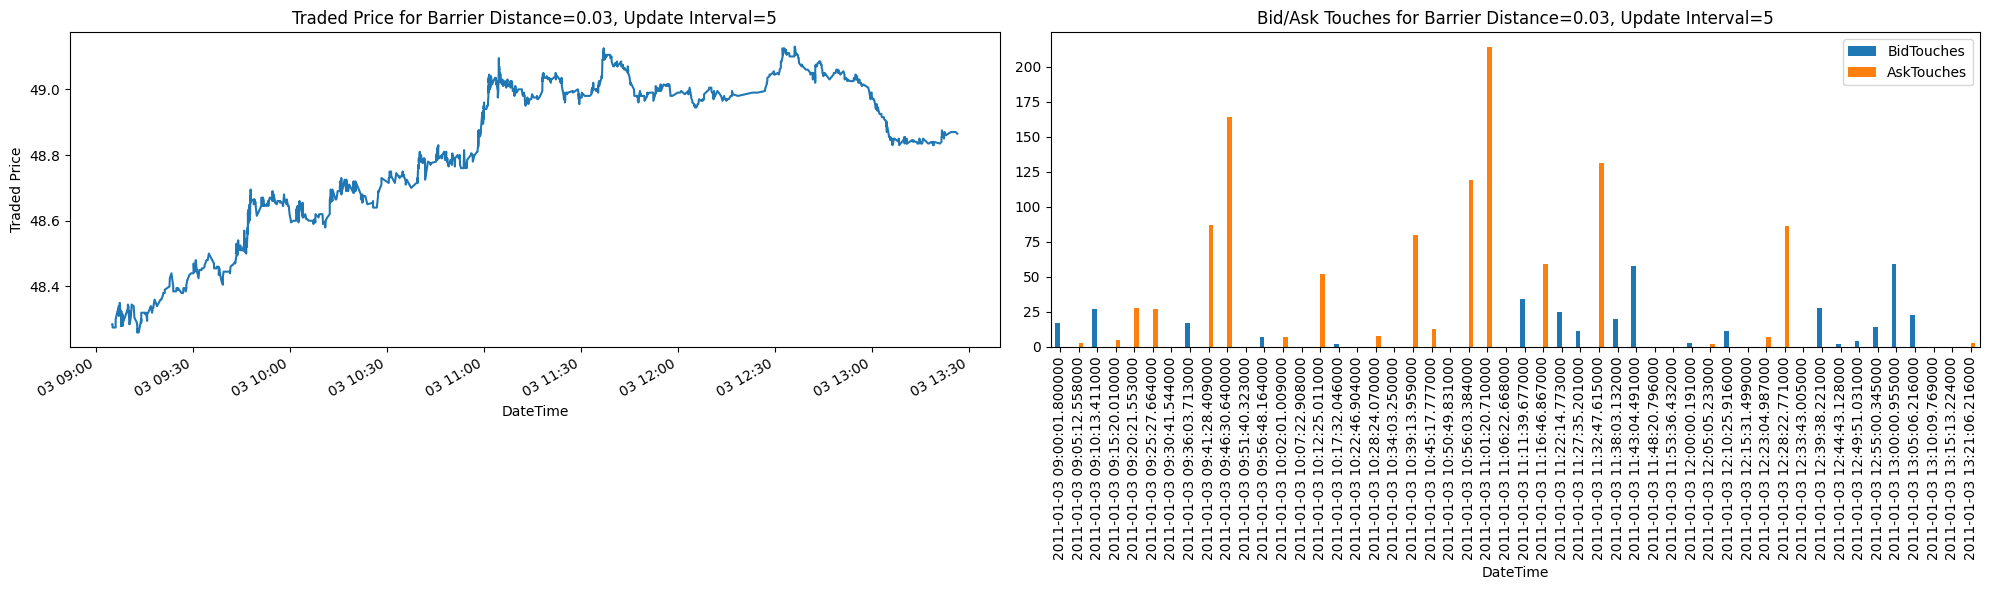

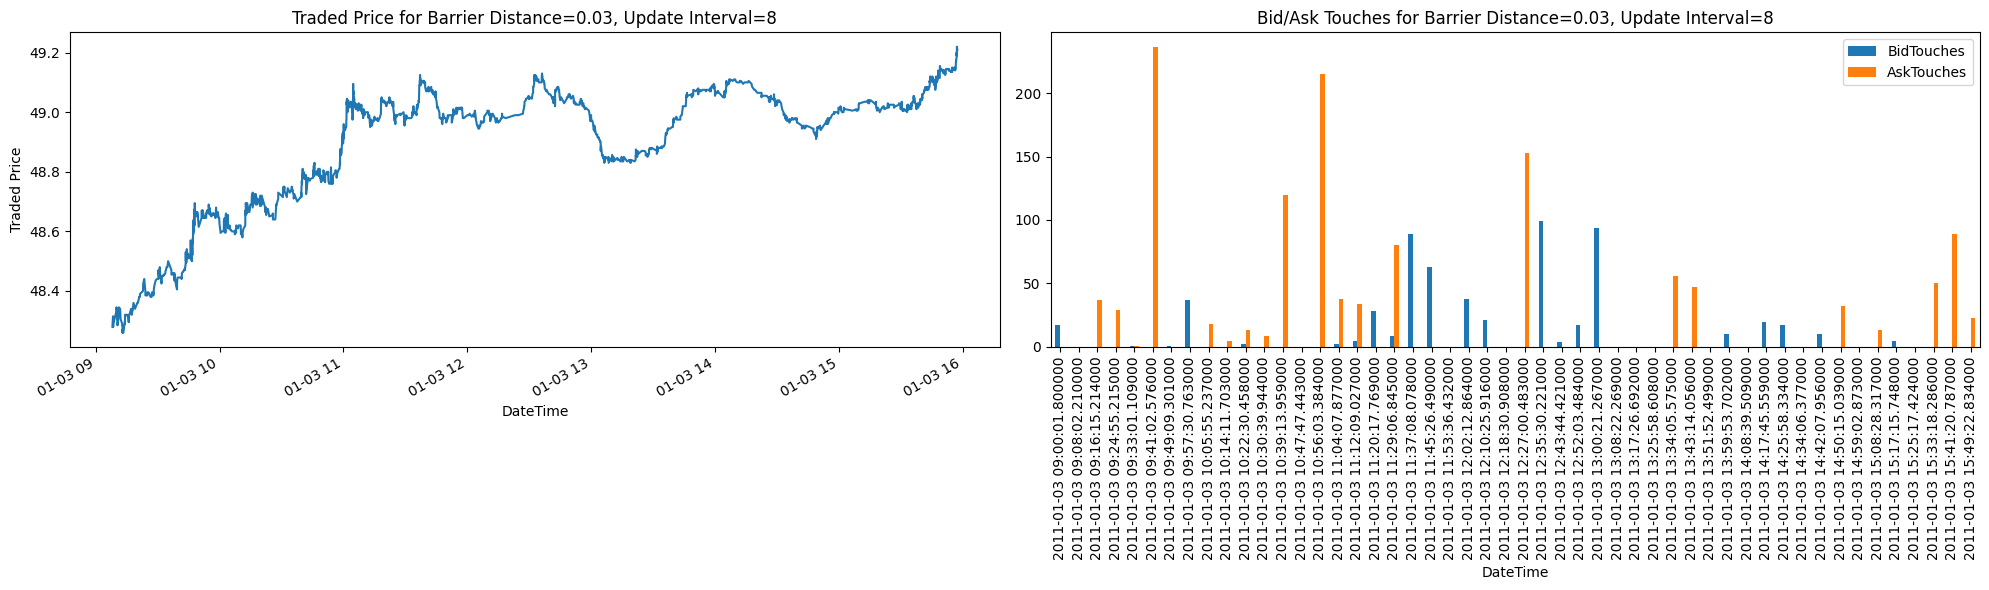

In [19]:
fillrate = Fillrates(df_sanofi)

# Valeurs de d et t à tester
d_values = [0, 0.01, 0.02, 0.03]
t_values = [1, 5, 8]

for d in d_values:
    for t in t_values:
        fillrate.plot_simulation(d, t)

Très logiquement, l'augmentation de l'horizon $t$ augmente le nombre de fois où la barrière est touchée. De la même façon, on observe qu'en réduisant la distance $d$, la barrière est davantage atteinte.

### 2. Inventory and Market Making

#### a) Inventory

On effectue le compte avec la méthode "count_touches" et on trace la surface afférente pour différente valeur de la distance et de l'horizon :

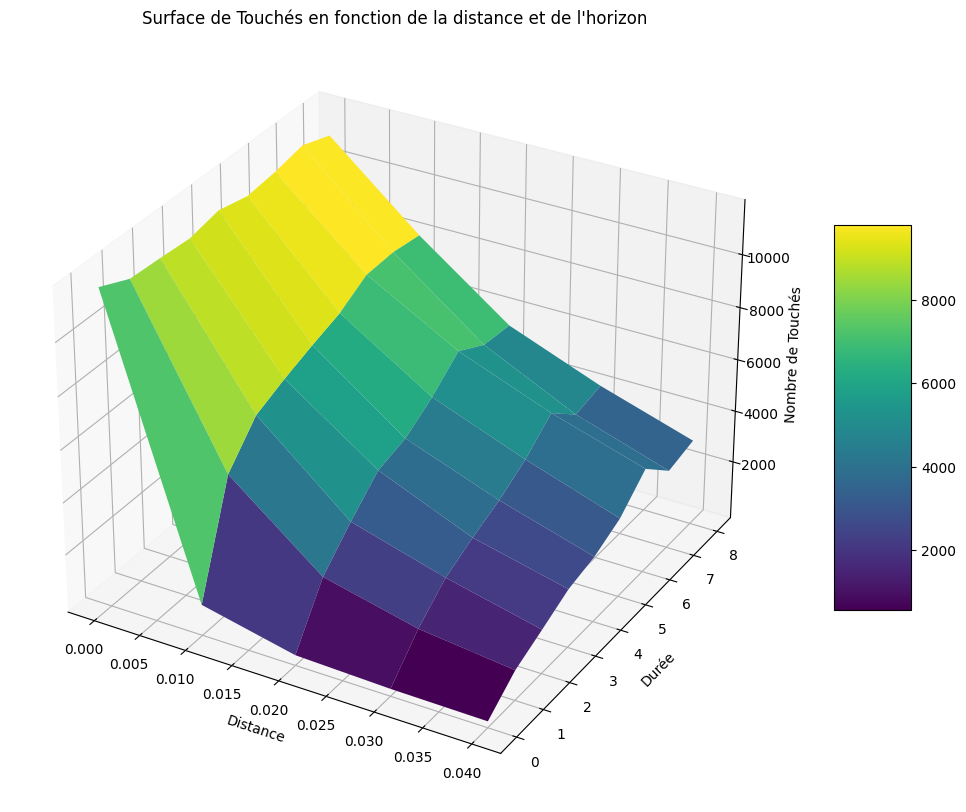

In [20]:
fillrate = Fillrates(df_total)

# Exemple
fillrate.count_touches(0, 2)

# Initialisation des paramètres
distance_values = np.arange(0, 0.05, 0.01)
duration_values = np.arange(0, 9)

# Préparation du tableau de résultats
results = np.zeros((len(distance_values), len(duration_values)))

# Exécution de la simulation pour chaque combinaison de d et t
for i, d in enumerate(distance_values):
    for j, t in enumerate(duration_values):
        results[i, j] = fillrate.count_touches(d, t)

# Création du graphique 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

D, T = np.meshgrid(distance_values, duration_values)  # Grilles pour d et t
Z = results.T  # Transpose pour correspondre aux grilles D et T

# Tracé de la surface
surf = ax.plot_surface(D, T, Z, cmap='viridis')

# Personnalisation du graphique
ax.set_xlabel('Distance')
ax.set_ylabel('Durée')
ax.set_zlabel('Nombre de Touchés')
ax.set_title("Surface de Touchés en fonction de la distance et de l'horizon")

# Ajout de la barre de couleur pour la surface
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Les résultats sont intuitivement ceux obtenus à la partie précédente. 

In [21]:
df_lvmh = import_data('../Stock data/LVMH.h5', '2011-01-03', 20)
fillrate = Fillrates(df_lvmh)
df = fillrate.get_vol_spread_volume()
df

,Spread,vol,volumes
Time,,,
2011-01-03,0.071740,1.219363,1144
2011-01-04,0.067482,1.392299,1953
2011-01-05,0.069011,2.366387,5213
2011-01-06,0.060185,1.674398,2333
2011-01-07,0.073169,1.341981,3288
2011-01-10,0.066360,1.855570,3752
2011-01-11,0.068187,1.749468,3302
2011-01-12,0.069343,1.705201,2683
2011-01-13,0.063162,1.373990,2293


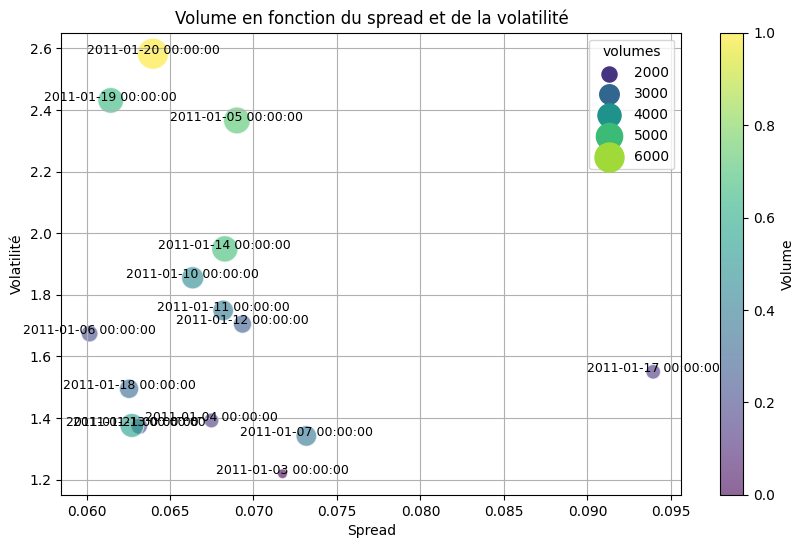

In [22]:
# Utiliser Seaborn pour tracer
plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(x='Spread', y='vol', size='volumes', data=df, sizes=(50, 500), hue='volumes', palette='viridis', alpha=0.6)

plt.xlabel('Spread')
plt.ylabel('Volatilité')
plt.title('Volume en fonction du spread et de la volatilité')

# Ajouter des annotations pour quelques points
for i in range(len(df)):
    plt.text(df['Spread'][i], df['vol'][i], df.index[i], fontsize=9, ha='center')

plt.grid(True)

# Obtenir l'objet mappable à partir du scatterplot
mappable = scatterplot.get_children()[0]

# Créer une barre de couleur basée sur l'objet mappable
plt.colorbar(mappable, label='Volume')

plt.show()

On observe que le volume est plus important lorsque la volatilité est importante. De manière générale, le volume a tendance à être important lorsque le spread est petit et la volatilité importante.

#### b) Static Market Making

In [32]:
df_lvmh = import_data('../Stock data/LVMH.h5', '2011-01-03', 15)

fillrate = Fillrates(df_lvmh)
best_da, best_db, inventaire = fillrate.get_best_da_db_inventory()

In [33]:
print(f"Pour un horizon t=1 minute, les optima pour da, db et l'inventaire sont respectivement {best_da}, {best_db} et le dernier inventaire est {inventaire[-1]}.")

Pour un horizon t=1 minute, les optima pour da, db et l'inventaire sont respectivement 0.001, 0.001 et le dernier inventaire est -4042.


On trace également une évolution de l'inventaire :

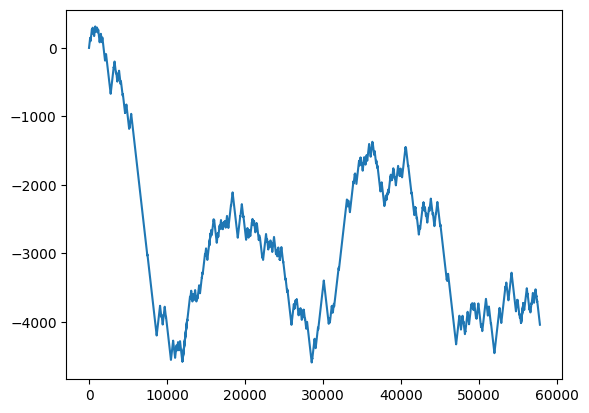

In [34]:
plt.figure()
plt.plot(inventaire)
plt.show()

On choisit par exemple de fixer ici que t = 5 minutes, pour rester en adéquation avec le graphique précédent. On voit que pour le 05 janvier 2011, la volatilité chez total était de 0.520624. On en déduit que : 

In [35]:
best_ca, best_cb = fillrate.get_best_ca_cb(best_da, best_db)

print(f'Les meilleurs ca et cb sont respectivement {np.round(best_ca, 4)} et {np.round(best_cb, 4)}.')

Les meilleurs ca et cb sont respectivement 0.0008 et 0.0008.


#### c) P&L Implementation

On trace le P&L pour différentes valeurs de da et db.

In [36]:
output = fillrate.get_pnl(best_ca, best_cb)
output

,inventory,price,PNL,Spread,vol
0,-2690.0,40.5025,-108951.725,0.071740,1.219363
1,-2690.0,41.1250,-110626.250,0.067482,1.392299
2,-2690.0,41.1950,-110814.550,0.069011,2.366387
3,-2690.0,41.5450,-111756.050,0.060185,1.674398
4,-2690.0,41.2225,-110888.525,0.073169,1.341981
5,-2690.0,40.7700,-109671.300,0.066360,1.855570
6,-2690.0,41.0575,-110444.675,0.068187,1.749468
7,-2690.0,41.7625,-112341.125,0.069343,1.705201
8,-2690.0,41.9900,-112953.100,0.063162,1.373990
9,-2690.0,42.4550,-114203.950,0.068284,1.949292


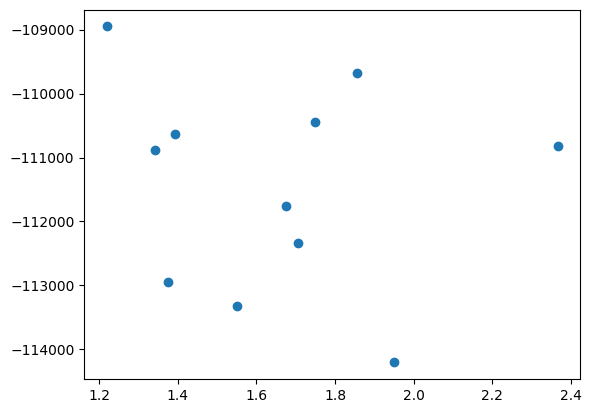

In [37]:
plt.scatter(output["vol"].values, output["PNL"].values)
plt.show()

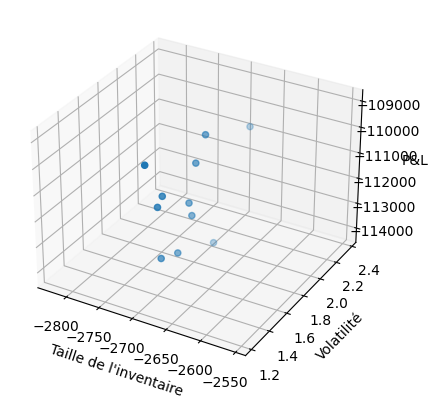

In [40]:
# Exemple de données
X = output["inventory"].values
Y = output["vol"].values
Z = output["PNL"].values

# Création d'une figure et d'un axe 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracé des données. Ici, vous pouvez utiliser scatter pour des points ou plot pour une ligne.
ax.scatter(X, Y, Z)

# Titres et labels
ax.set_xlabel('Taille de l\'inventaire')
ax.set_ylabel('Volatilité')
ax.set_zlabel('P&L')

plt.show()